# Calculate and plot meridional heat transport

## Uses two methods because of diagnostics available:
- From surface heat flux assuming steady state
- From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [1]:
%matplotlib inline

import pandas as pd
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as c
from dask.distributed import Client


import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/meridional_heat_transport"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# Set 1-degree data to be different for MHT diagnostics:
exptdata.exptdict['1deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle'
exptdata.exptdict['1deg']['expt'] = '1deg_jra55v13_iaf_spinup1_B1_lastcycle'

tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
#cc.start_cluster()
client = Client("tcp://10.6.122.47:8786")
client

<Client: 'tcp://10.6.122.47:8786' processes=1 threads=28, memory=126.00 GiB>

In [5]:
session = cc.database.create_session()

In [6]:
# use int_z MHT diagnostics:
def find_MHF_intz(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    # n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    darray = cc.querying.getvar(session=session, expt=expt, variable='temp_yflux_adv_int_z', n=n_files, use_cache=False)
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    temp_yflux_adv = darray
    darray = cc.querying.getvar(session=session, expt=expt, variable='temp_yflux_submeso_int_z', n=n_files)
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    temp_yflux_submeso = darray
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        darray = cc.querying.getvar(session=session, expt=expt, variable='temp_yflux_gm_int_z', n=n_files)
        if offset:
            td = pd.Timedelta(days=offset)
            darray = darray.assign_coords(time=darray.time + td)
        temp_yflux_gm = darray
        darray = cc.querying.getvar(session=session, expt=expt, variable='temp_yflux_ndiffuse_int_z', n=n_files)
        if offset:
            td = pd.Timedelta(days=offset)
            darray = darray.assign_coords(time=darray.time + td)
        temp_yflux_ndiffuse = darray
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()

    darray = cc.querying.getvar(session=session, expt=expt, variable='yu_ocean', n=1)
    latv = darray.load()
    return latv, MHF

(-2.0, 2.5)

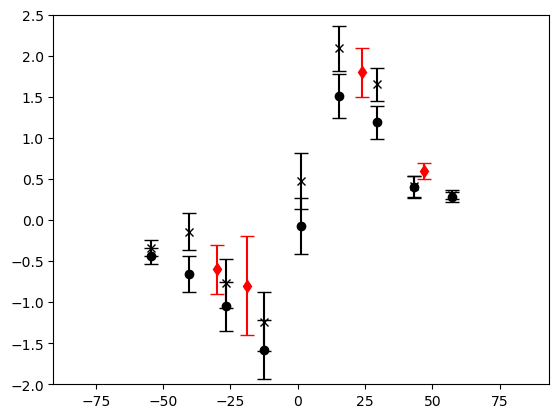

In [7]:
# Read in observed meridional heat transport from Trenberth and Caron (http://www.cgd.ucar.edu/cas/catalog/ocean/ohts/rean_ohts.html)
df=pd.read_csv('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', sep=' ',skiprows=1,skipinitialspace=True)
obs_lat = df.values[:,0]/100.
obs_ncep = df.values[:,6]/100.
obs_ncep_er = df.values[:,10]/100
obs_ecmwf = df.values[:,14]/100.
obs_ecmwf_er = df.values[:,18]/100.
plt.errorbar(obs_lat[::5],obs_ncep[::5],yerr=obs_ncep_er[::5],fmt='xk',capsize=5)
plt.errorbar(obs_lat[::5],obs_ecmwf[::5],yerr=obs_ecmwf_er[::5],fmt='ok',capsize=5)
plt.ylim([-2, 2.5])

# Read in observed MHT from Ganachaud and Wunsch 2000 (
df=pd.read_csv('GW2003_GlobalMHT.txt', sep=' ',skiprows=0,skipinitialspace=True)
obsGW2003_lat = df.values[:,0]
obsGW2003_mht = df.values[:,1]
obsGW2003_mhte = df.values[:,2]
plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dr',capsize=5)
plt.ylim([-2, 2.5])

VariableNotFoundError: No files were found containing 'temp_yflux_adv_int_z' in the '1deg_jra55v13_iaf_spinup1_B1_lastcycle' experiment

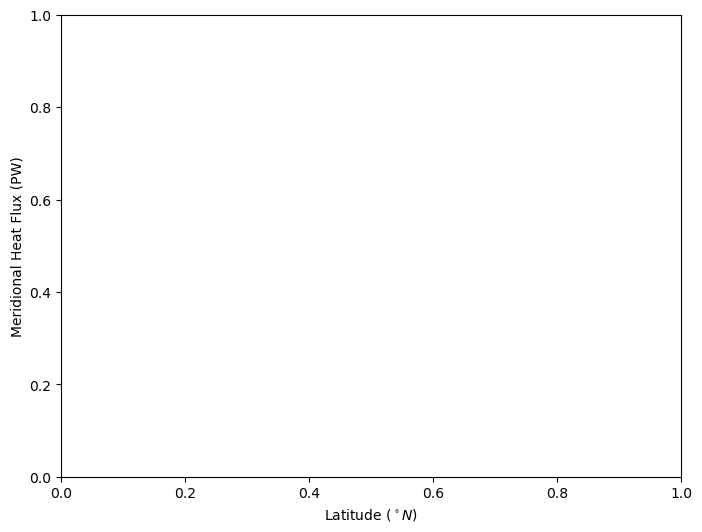

In [8]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF_intz(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
plt.errorbar(obs_lat[3::5],obs_ncep[3::5],yerr=obs_ncep_er[3::5],fmt='xk',capsize=3)
plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
plt.errorbar(obs_lat[::5],obs_ecmwf[::5],yerr=obs_ecmwf_er[::5],fmt='ok',capsize=3)
plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dr',capsize=8,label='GW2003')
plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

savefigure('meridional_heat_transport_intz_withobs')

In [9]:
cc.querying.get_ncfiles(session=session, experiment=exptdata.exptdict['1deg']['expt'])

,ncfile,index_time


In [10]:
cc.querying.get_variables(session=session, experiment=exptdata.exptdict['1deg']['expt'])

,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end


In [11]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    darray = cc.querying.getvar(session=session, expt=expt, variable='net_sfc_heating', n=n_files, use_cache=True)
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    shflux = darray
    shflux_am = shflux.mean('time').load()
    darray = cc.querying.getvar(session=session, expt=expt, variable='area_t', n=1)
    area = darray.load()
    darray = cc.querying.getvar(session=session, expt=expt, variable='geolat_t', n=1)
    lat = darray.load()
    darray = cc.querying.getvar(session=session, expt=expt, variable='yt_ocean', n=1)
    latv = darray.load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

VariableNotFoundError: No files were found containing 'net_sfc_heating' in the '1deg_jra55v13_iaf_spinup1_B1_lastcycle' experiment

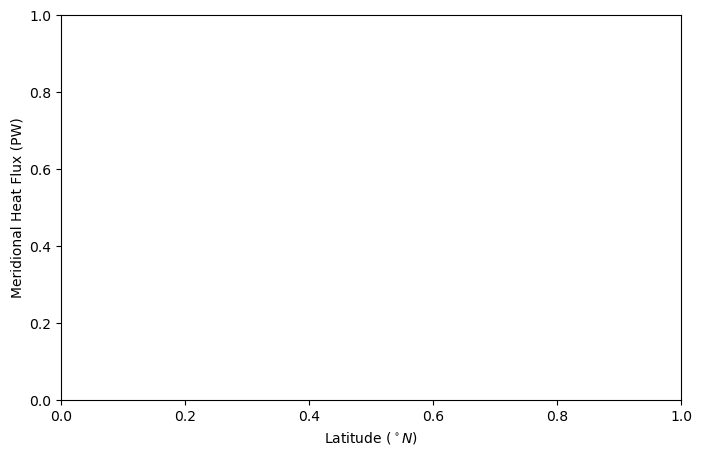

In [12]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')